In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline,interp1d 
from os import listdir,path,walk
import matplotlib as mpl
from scipy.signal import savgol_filter
import lmfit as lm
import scipy.stats as stats
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import date

mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.linewidth'] = 1.5
pd.options.display.float_format = '{:,.4f}'.format

# Functions

In [3]:
def load_single_file(path,drop=True):
    f = pd.read_csv(path)
    if drop:
        if type(f["TRACK_ID"].iloc[0])==str:
            if drop:
                f=f[3:]     
                f=f.drop("LABEL",1)
        f=f.apply(pd.to_numeric, errors='coerce')   

    return(f)

In [4]:

def generalized_gaussian(x,a,b,c,off,to):
    return(c*np.exp(-a*((x-to)**2)**b)+off)

class make_average():    
        
    def __init__(self,data,plot_params,do_mosaic):              
        self.data       = data
        self.ntracks    = len(data)        
        self.plot_params= plot_params
        self.do_mosaic  = do_mosaic
    
        
    def loading_inten_file(self,idc):        
        data_track = self.data_track.copy()
        idp = data_track["Protein"].values[0]
        idf,ids,to,tf,xo,yo = data_track[["FILE_ID","SET_ID",
                                            "TRACK_START","TRACK_STOP",
                                            "TRACK_X_LOCATION","TRACK_Y_LOCATION"]].astype(int).values[0]  
        
        homec = home + "Results/Intensity_Profiles/%s"%idp
        if idc==1:
            input_folder = homec+"/Replicate_%s"%ids
            inten  = pd.read_csv(input_folder+"/Results_x_%d_Y_y_%d_from_%d_to_%d_set_%s_file_%d_C%d.csv"%
                        (xo,yo,to,tf,ids,idf,idc))
            self.lent = len(inten)            

        if idc==2:
            input_folder = homec+ "/Sel_Tracks"

            try:
                inten  = pd.read_csv(input_folder+"/Results_x_%d_Y_y_%d_from_%d_to_%d_set_%s_file_%d_C%d.csv"%
                        (xo,yo,to,tf,ids,idf,idc))
            except:
                print("Warning: File  ", input_folder+"/Results_x_%d_Y_y_%d_from_%d_to_%d_set_%s_file_%d_C%d.csv"%
                        (xo,yo,to,tf,ids,idf,idc))

            if ids > 0 and idp != "Sec17":
                inten["Frame"] += max(to-27,0)
                inten.index    += max(to-27,0)

                for k in range(0,min(inten.index)):
                    inten.at[k,:] = 0
                    inten.at[k,"Frame"] = k
                for k in range(max(inten.index),self.lent):
                    inten.at[k,:] = 0
                    inten.at[k,"Frame"] = k  
                inten.sort_index(inplace=True)        
        self.inten = inten

    def run_average(self):
    
        do_mosaic = self.do_mosaic
        data      = self.data.copy()
        params    = self.plot_params        

        ids_WalkAv = params["Raw"]
        BG         = params["BG"]            
        norm       = params["Norm"]
        id_x       = params["IdX"]
        do_aligned = params["do_aligned"]            
        do_savfil  = params["do_savfil"]
        show_C2    = params["show_C2"]
        show_fit   = params["show_fit"]

        f_in ={}
        f_fil={}
        f_bg ={}
        ts  = np.arange(-60,60,0.2)

        inten_exo84  = np.zeros_like(ts)
        inten2_exo84 = np.zeros_like(ts)

        ntracks  = 0 
        intenC2  = {}        
        intenC1  = {}

        for idprot,idp in enumerate(data["Protein"].unique()):

            data_sel = data.query("Protein == '%s'"%idp).copy()

            if do_mosaic:            
                cols = int(np.sqrt(len(data_sel))) 
                rows = len(data_sel)//cols + 1
                fig,axes  = plt.subplots(rows,cols,figsize=(5*cols,5*rows))
                axes = np.ravel(axes)

            idfig = 0                

            inten_C2     = np.zeros_like(ts)    
            inten2_C2    = np.zeros_like(ts)
            inten_C1     = np.zeros_like(ts)    
            inten2_C1    = np.zeros_like(ts)
            np_tracks    = 0    

            for l,id in enumerate(data_sel.index):            

                data_track = data_sel.loc[id:id].copy()
                self.data_track = data_track
                fr,idp,idf,ids,to_C1,tf_C1,to_C2,tf_C2 = data_track[["FR","Protein",
                                                "FILE_ID","SET_ID",
                                                "TRACK_START","TRACK_STOP",
                                                "To_CH2","Tf_CH2"]].values[0]                        
                dur_C1= (tf_C1-to_C1)*fr            
                to_C2 = int(data_sel.loc[id,"To_CH2"]/fr+ to_C1)
                tf_C2 = int(data_sel.loc[id,"Tf_CH2"]/fr + to_C1)               

                shift_C1= (tf_C1+to_C1)/2  # All timepoints are defined respect to track_center_C1 by default           
                to_C1   = (to_C1-shift_C1)*fr 
                tf_C1   = (tf_C1-shift_C1)*fr 
                to_C2   = (to_C2-shift_C1)*fr
                tf_C2   = (to_C2-shift_C1)*fr
                shift_C2= (to_C2+tf_C2)/2 *fr

                for idc in [1,2]:

                    Imax  = data_track["Imax_C%d"%idc].values[0]
                    self.loading_inten_file(idc)
                    inten = self.inten.copy()
                    
                    f_in["C%d"%idc]  = inten["Mean_X%s"%id_x]  if ids_WalkAv  else inten["Mean_DoG_X%s"%id_x]                
                    f_fil["C%d"%idc] = savgol_filter(f_in["C%d"%idc],3,1) 
                    f_bg["C%d"%idc]  = inten["Mean_BG_X%s"%id_x]  if ids_WalkAv else inten["Mean_DoG_BG_X%s"%id_x] 

                    if BG:    
                        f_in["C%d"%idc]  = f_bg["C%d"%idc]                 
                        f_fil["C%d"%idc] = savgol_filter(f_in["C%d"%idc],3,1) 

                    if norm:
                        f_in["C%d"%idc]  = f_in["C%d"%idc]/Imax                                        
                        f_fil["C%d"%idc] = f_fil["C%d"%idc]/Imax

                if do_savfil:
                    f_in["C1"] = f_fil["C1"]
                    f_in["C2"] = f_fil["C2"]                 
                
                t = np.arange(len(f_in["C1"]))-shift_C1
                t = t*fr                      

                if do_mosaic: 
                    ax  = axes[idfig]   
                    idcs= [1,2] if show_C2 else [1]

                    for i,idc in enumerate(idcs): 
                        y  = f_in["C%d"%idc]
                        sel= (t>to_C1-5)&(t<tf_C1+5)
                        x  = t[sel]
                        y  = y[sel]      
                        y /= np.max(y) if show_C2 else 1

                        feat = [ f + "_C%d"%idc for f in ["Tau","B","C","Offset","Tc","R2"] ]
                        if show_fit:                                       
                            tau,b,cc,off,tc,r2 = data_track[feat].values[0]
                            a   = 1/tau**(2*b)                    
                            yf = generalized_gaussian(x,a,b,cc,off,tc)                
                            yf/= np.max(yf) if show_C2 else 1
                            ax.plot(x,yf,'k-',label='fit\nR2: %.3f'%r2)

                        ax.plot(x,y,'-',color=['r','g'][i])#,label='Exp')
                    #ax.axvline(too*fr,color='gray',ls='--')
                    #ax.axvline(tff*fr,color='gray',ls='--')
                    #ax.axvline(tc_CH2,color='lightgreen',ls='--')
                    ax.text(0.5,0.1,"Dur: %.2f s"%(dur_C1),ha='center', transform=ax.transAxes,fontsize=14)                

                    #ax.set_title("Rep. %d - FOV %d - x/y:%d-%d'"%(ids,idf,xo,yo),fontsize=14)
                    #ax.legend(fontsize=10,loc="upper right")

                idfig += 1
                #print(idp,idfig)
                #++++++++++++++++++++++++++++++++++++++++++++++++  
                tc_fit_C1 = data_track["Tc_C1"].values[0]
                centers = {
                    "Arrival"    :to_C1, # To be defined according to fitting
                    "Departure"  :tf_C1, # To be defined according to fitting
                    "Track_Start":to_C1,
                    "Track_Stop" :tf_C1,
                    "Center"     :0,
                    "Fit_Center" :tc_fit_C1,
                    "Center_CH2" :shift_C2
                }
                t_zero = centers[do_aligned]
                t      = t - t_zero
                #++++++++++++++++++++++++++++++++++++++++++++++++

                y = f_in["C1"]
                y = UnivariateSpline(t,y,k=3, s=0)  
                y = y(ts)
                y[(ts<t[0]) | (ts>t[-1])] = 0
                inten_exo84 += y
                inten2_exo84+= y**2 
                inten_C1 += y
                inten2_C1+= y**2 

                y = f_in["C2"]
                y = UnivariateSpline(t,y,k=3, s=0)  
                y = y(ts)
                y[(ts<t[0]) | (ts>t[-1])] = 0
                inten_C2 += y
                inten2_C2+= y**2 

                ntracks  += 1
                np_tracks+= 1

            inten_C2  /= np_tracks
            inten2_C2 /= np_tracks             
            std_C2     = np.sqrt(inten2_C2-inten_C2**2)
            intenC2[idp] = [inten_C2,std_C2,np_tracks]
            
            inten_C1  /= np_tracks
            inten2_C1 /= np_tracks             
            std_C1     = np.sqrt(inten2_C1-inten_C1**2)
            intenC1[idp] = [inten_C1,std_C1,np_tracks]

            if do_mosaic:
                for j in range(idfig,rows*cols):
                    ax = axes[j]
                    ax.remove()  
                    #print("removing", j)
                fig.suptitle(idp)
                plt.tight_layout()
                if show_C2:
                    plt.savefig("Figures/Mosaic_Tracks_%s_C2.png"%idp,dpi=200,facecolor="w")
                else:
                    plt.savefig("Figures/Mosaic_Tracks_%s.png"%idp,dpi=200,facecolor="w")
                plt.close()

        inten_exo84 /= ntracks
        inten2_exo84/= ntracks 
        std_exo84 = np.sqrt(inten2_exo84-inten_exo84**2)    

        return(ts,inten_exo84,std_exo84,ntracks,intenC2,intenC1)    

# Two-Channel  tracking

In [9]:
# Raw -> True: Plot intensity over  Raw Image -- False: Over DoG Image
# BG  -> True: Substract local background
# Norm-> Normalized each track before averaging
# IdX -> "" -> Following spot  --- "m" --> Mean localization --"t" --> Tethering localization        
# do_aligned --> "Center","Track_start","Track_stop","Center_CH2","Fit_Center"
# do_savfil  --> Apply savgol filter

data_CH1 = pd.read_csv("Final_ManualSel_Updated_2024-07-29_fitted.csv")
home = "/home/jsortiz/phd/tracking/scripts/intensity_profile/For_SuperResPaper/"

plot_params = {"Raw":True,
               "BG":True,
               "Norm":True,
               "IdX":"",
               "do_aligned":"Track_Stop",
               "do_savfil":False,
               "show_C2": True,
               "show_fit": True} 
averaging =  make_average(data_CH1,plot_params=plot_params,do_mosaic=False)
ts,inten_exo84,std_exo84,ntracks,intenC2,intenC1 = averaging.run_average()

In [10]:
colors = {"Sec9":'orange',"Sec2":'brown','Sec18':'purple'}

### Figure 3C: Correlation between Exo84-mCh tracks maximum corrected intensity and duration

Replicate All --  R_value : 0.28 	p_value : 0.01  Ntracks: 89


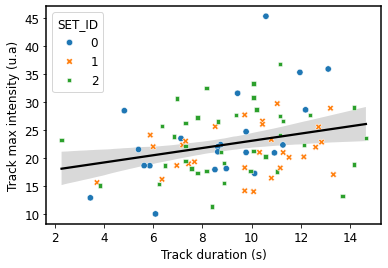

Replicate   0 --  R_value : 0.56 	p_value : 0.01  Ntracks: 22
Replicate   1 --  R_value : 0.25 	p_value : 0.19  Ntracks: 29
Replicate   2 --  R_value : 0.16 	p_value : 0.33  Ntracks: 38


In [22]:
from sklearn import datasets, linear_model

### Using Raw Imax
data_aux = data_CH1.query(" Protein in ['Sec2','Sec18','Sec9'] and Dur<16 and Dur>0").copy()
fit = stats.linregress(data_aux["Dur"],data_aux["Imax_C1"])
print("Replicate All -- ","R_value : %.2f" %fit.rvalue, "\tp_value : %.2f"%fit.pvalue," Ntracks: %d"%len(data_aux))

sns.regplot(data=data_aux,x="Dur",y="Imax_C1",scatter_kws={"s":0},color='k')
sns.scatterplot(data=data_aux,x="Dur",y="Imax_C1",hue="SET_ID",palette='tab10',style="SET_ID",s=40)

plt.xlabel("Track duration (s)")
plt.ylabel("Track max intensity (u.a)")
plt.savefig("Figures/Correlation_Dur_MaxI.svg")
plt.show()

for ids in [0,1,2]:    
    fit = stats.linregress(data_aux.query("SET_ID==@ids")["Dur"],data_aux.query("SET_ID==@ids")["Imax_C1"])
    print("Replicate %3d -- "%ids,"R_value : %.2f" %fit.rvalue, "\tp_value : %.2f"%fit.pvalue,
          " Ntracks: %d"%len(data_aux.query("SET_ID==@ids")))


In [23]:
stats.pearsonr(data_aux["Dur"],data_aux["Imax_C1"])

(0.278118975283803, 0.008316071900693226)

### Fig_S11: Correlation between the release dynamics of exocyst and other protein clusters 
### Fig_5C: Sec18 is necessary for the exocyst to depart from exocytic sites


,slope,intercept,rvalue,pvalue,stderr,Protein,R2
0,-0.0050,-1.2254,-0.0108,0.9517,0.0817,Sec2,0.0001
1,0.5351,-1.4625,0.4803,0.0013,0.1545,Sec9,0.2307
2,0.9407,0.4746,0.8412,0.0003,0.1823,Sec18,0.7076


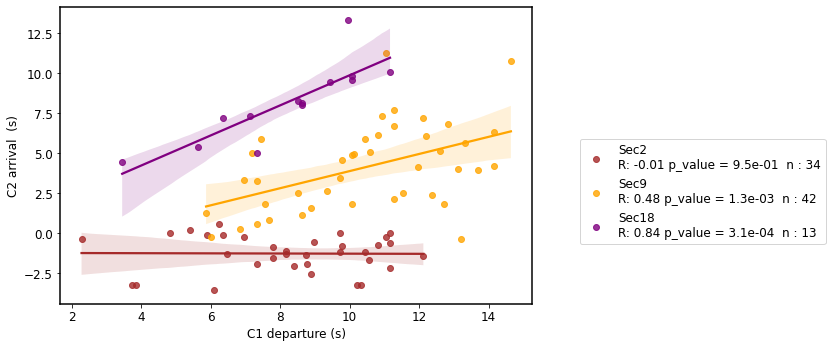

In [18]:
## Correlation between C2_arrival_time and C1_departure_time
#Fig_4C: Sec18 is necessary for the exocyst to depart from exocytic sites
fit = []
plt.figure(figsize=(12,5))
for i in ["Sec2","Sec9","Sec18"]:
    data = data_CH1.query("""Protein==@i and Dur<15""").copy()
    x = data["Dur"]
    y = data["To_CH2"]
    p = list(stats.linregress(x,y))+[i]
    fit.append(p)
    sns.regplot(data=data,x=x,y=y,
                label= "%s\nR: %4.2f p_value = %.1e  n : %d"%(i,p[2],p[3],len(data)),color=colors[i])
plt.legend(loc=[1.1,0.2])
plt.ylabel("C2 arrival  (s)")
plt.xlabel("C1 departure (s)")
plt.tight_layout()
plt.savefig("Figures/Paper_plots/Correlation_plot_C2arrivaltime.svg",dpi=200)
plt.savefig("Figures/Paper_plots/Correlation_plot_C2arrivaltime.png",dpi=200)
fit = pd.DataFrame(fit,columns=["slope","intercept","rvalue","pvalue","stderr","Protein"])
fit["R2"] = fit["rvalue"]**2
#fit.to_csv("Correlation_fit_C2arrivaltime.csv")
fit

,slope,intercept,rvalue,pvalue,stderr,Protein,R2
0,-0.2067,0.9028,-0.1834,0.2991,0.1958,Sec2,0.0336
1,-0.1089,3.6352,-0.2139,0.1738,0.0786,Sec9,0.0458
2,-0.0321,4.5812,-0.0597,0.8463,0.1618,Sec18,0.0036


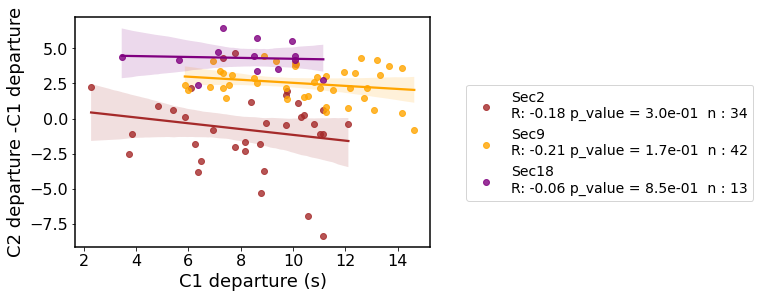

In [29]:
#Fig_S13A: Correlation between the C1 release and  C2 release times

fit = []
plt.figure(figsize=(12,5))

for i in ["Sec2","Sec9","Sec18"]:    
    data = data_CH1.query("""Protein==@i and Dur<15""").copy()
    x = data["Dur"]
    y = data["Tf_CH2"]-data["Dur"]
    p = list(stats.linregress(x,y))+[i]
    fit.append(p)
    sns.regplot(data=data,x=x,y=y,
                label= "%s\nR: %4.2f p_value = %.1e  n : %d"%(i,p[2],p[3],len(data)),color=colors[i])
plt.legend(loc=[1.1,0.2])
plt.ylabel("C2 departure -C1 departure")
plt.xlabel("C1 departure (s)")
plt.tight_layout()
plt.savefig("Figures/Paper_plots/Correlation_plot_C2departuretime_v2.svg",dpi=200)
plt.savefig("Figures/Paper_plots/Correlation_plot_C2departuretime_v2.png",dpi=200)
fit = pd.DataFrame(fit,columns=["slope","intercept","rvalue","pvalue","stderr","Protein"])
fit["R2"] = fit["rvalue"]**2
#fit.to_csv("Correlation_fit_C2departuretime_v2.csv")
fit

,slope,intercept,rvalue,pvalue,stderr,Protein,R2
0,-1.0050,-1.2254,-0.9086,0.0000,0.0817,Sec2,0.8256
1,-0.4649,-1.4625,-0.4296,0.0045,0.1545,Sec9,0.1845
2,-0.0593,0.4746,-0.0976,0.7511,0.1823,Sec18,0.0095


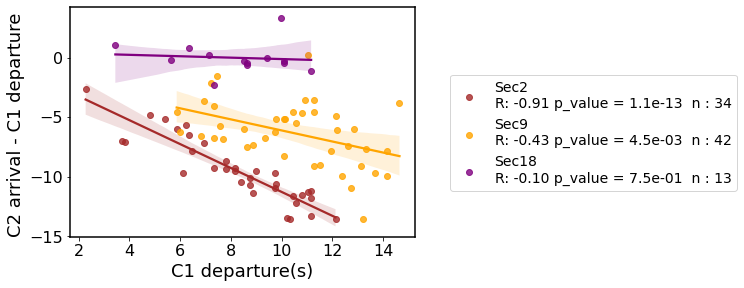

In [30]:
#Fig_S13A: Correlation between the C1 release and  C2 clustering times
fit = []
plt.figure(figsize=(12,5))
for i in ["Sec2","Sec9","Sec18"]:    
    data = data_CH1.query("""Protein==@i and Dur<15""").copy()
    x = data["Dur"]
    y = data["To_CH2"]-data["Dur"]        
    p = list(stats.linregress(x,y))+[i]
    fit.append(p)
    sns.regplot(data=data,x=x,y=y,
                label= "%s\nR: %4.2f p_value = %.1e  n : %d"%(i,p[2],p[3],len(data)),color=colors[i])
plt.legend(loc=[1.1,0.2])
plt.ylabel("C2 arrival - C1 departure ")
plt.xlabel("C1 departure(s)")
plt.tight_layout()
plt.savefig("Figures/Paper_plots/Correlation_plot_C2arrivaltime_C1arrival.svg",dpi=200)
plt.savefig("Figures/Paper_plots/Correlation_plot_C2arrivaltime_C1arrival.png",dpi=200)
fit = pd.DataFrame(fit,columns=["slope","intercept","rvalue","pvalue","stderr","Protein"])
fit["R2"] = fit["rvalue"]**2
fit.to_csv("Correlation_fit_C2arrivaltime_C1arrival.csv")
fit

### Fig3D: Average intensity separately

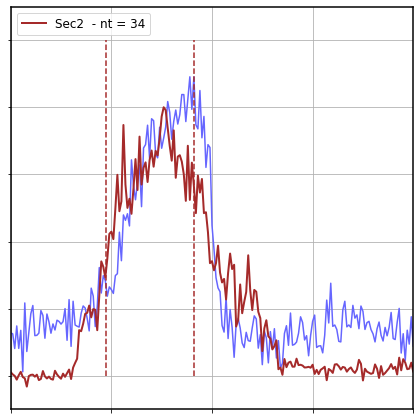

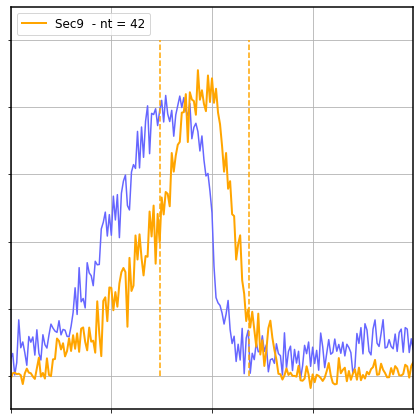

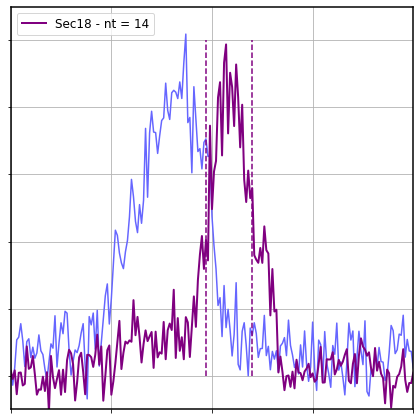

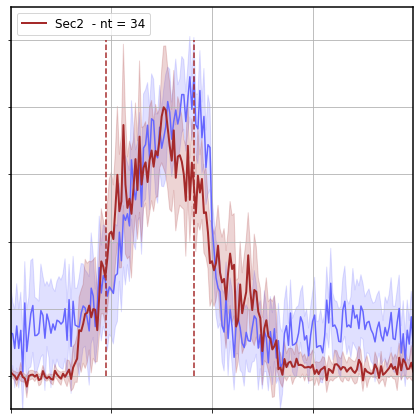

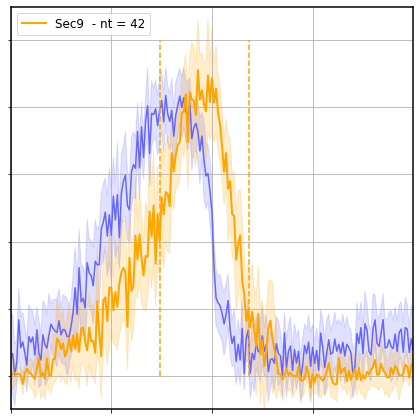

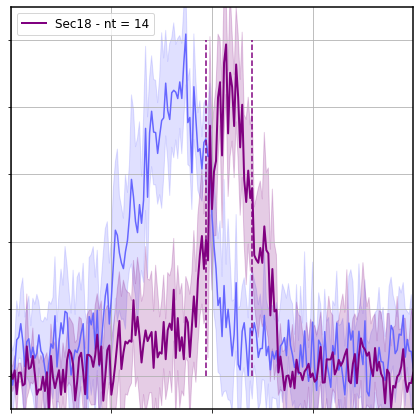

In [24]:
colors = {"Sec9_AA":"c","Sec2":"brown","Control":"b","Sec9":"orange","Sec18":"purple","Sec17":"y",
         "Exocyst":[102/255,102/255,255/255]}

np.savetxt("Final_Data_Timeline/allprots_exo84.dat",
          np.stack((ts,inten_exo84,std_exo84),axis=1))
exodur = 9.4

for j,s in enumerate(['',"CI"]):
    for idp in ["Sec2","Sec9","Sec18"]:
        plt.figure(figsize=(6,6))
        
        data_aux= data_CH1.query("Protein=='%s'"%idp).copy()
        exodur  = data_CH1["Dur"].median()
        
        data  = intenC1[idp].copy()
        sd    = data[1].copy()
        y     = data[0].copy()
        #y  = savgol_filter(y,10,1) #/np.max(y[0])    
        #sd = savgol_filter(std_exo84,10,1) #/np.max(y[0])    
        sd    =  sd/np.sqrt(data[2])*1.95
        #y /= np.max(y)       
        plt.plot(ts,y,color=colors["Exocyst"])
        
        if s == "CI": 
            plt.fill_between(ts,y-sd,y+sd,color=colors["Exocyst"],alpha=0.2)     
            
        data  = intenC2[idp].copy()
        sd    = data[1].copy()
        y     = data[0].copy()
        #sd   /= np.max(y)
        #y    /= np.max(y)
        
        if s  != "CI":
            np.savetxt("Final_Data_Timeline/%s_%dtracks.dat"%(idp,data[2]),
                       np.stack((ts,y,sd),axis=1))
            
        #y     = savgol_filter(y,10,1) #/np.max(y[0])    
        #y     /= np.max(y)
        plt.plot(ts,y,label=idp.ljust(6) + r"- nt = %d"%data[2],color=colors[idp],lw=2)    
        sd    =  sd/np.sqrt(data[2])*1.95
        #sd    =  savgol_filter(sd,10,1)
        if s == "CI":
            plt.fill_between(ts,y-sd,y+sd,alpha=0.2,color=colors[idp])    
        
       
        data_aux= data_CH1.query("Protein=='%s'"%idp).copy()
        #n = len(data_sel)
        to     = data_aux["To_CH2"].mean() - exodur  
        to_std = data_aux["To_CH2"].std()  - exodur

        #too = too + to 
        tf     = data_aux["Tf_CH2"].mean() -exodur
        tf_std = data_aux["Tf_CH2"].std()  -exodur
        
        plt.vlines([to,tf],0,1,color=colors[idp],ls='--')

        #plt.legend(loc=[1.1,0.2])
        plt.legend(loc='upper left',fontsize=12)
        #plt.ylabel("Normalized Intensity",fontsize=16)        
        #plt.xlabel("Time (s)",fontsize=16)    
        plt.xticks(np.arange(-20,21,10),labels=[])
        plt.yticks(np.arange(0,1.1,0.2),labels=[])    
        plt.xlim(-20,20)
        plt.ylim(-0.1,1.1)        
        plt.grid()    
        #ax = plt.gca()
        #ax.set_facecolor(".96")        
        plt.tight_layout()
        plt.savefig("Figures/Paper_plots/Timeline_%s_%s.png"%(s,idp),dpi=200,facecolor='w')
        plt.savefig("Figures/Paper_plots/Timeline_%s_%s.svg"%(s,idp))
    

# Live-Cell Copy number

## Functions

In [ ]:
#+++++++++++++++++++++++To calculate copy number and errors++++++++++++++++

def errn(intens_tar,intens_ref,n_ref,err_nref):    
    
    #+++++++++++++++++++++++
    #Picco, Andrea, et al. "Visualizing the functional architecture of the endocytic machinery." Elife 4 (2015): e04535.
    #See "Quantification of the number of molecules" in Methods
    #The target copy number n_tar is estimated as 
    #       n_tar    = i_tar/i_ref * n_ref   
    #The n_tar error (err_ntar) is calculated as: 
    #       err_ntar = sqrt ( (n_tar/n_ref * err_nref)**2 + (n_tar/i_tar*err_itar)** + (n_tar/i_ref*err_iref)**2 )     
    #Where: 
    # i_tar   : Median Corrected Total Intensity (CTI) of the target protein 
    # i_ref   : Median CTI of the reference protein (Cse4 in our case)
    # n_ref   : Copy number of the reference protein ( = 76.8) [See Cieslinski, K, et al.,2023,https://doi.org/10.1083/jcb.202209094]
    # err_nref: Error associated to n_ref  ( = 9.8)[See Cieslinski, K, et al.,2023,https://doi.org/10.1083/jcb.202209094]
    # err_itar: Error associated to i_tar
    # err_iref: Error associated to i_ref
    #-----------------------
    # err_iref and err_itar are computed by following the next steps (here inten should be replaced by err_iref o err_tar)
    # l     = np.log(inten)    
    # err_l =  1.4826 * MAD(l) / np.sqrt(n)  ::: n = len(inten) -- The number of patches
    #-----------------------    
    #+++++++++++++++++++++++
 
    
    i_tar  = np.median(intens_tar)
    i_ref  = np.median(intens_ref)

    l       = np.log(intens_tar)
    mad_l   = stats.median_abs_deviation(l)
    sigma_l = 1.4826*mad_l/np.sqrt(len(l))
    err_itar= i_tar*sigma_l
    
    l       = np.log(intens_ref)
    mad_l   = stats.median_abs_deviation(l)
    sigma_l = 1.4826*mad_l/np.sqrt(len(l))
    err_iref= i_ref*sigma_l    
    
    n_tar    = i_tar/i_ref*n_ref
    err_ntar = np.sqrt((n_tar/n_ref*err_nref)**2+(n_tar/i_tar*err_itar)**2+(n_tar/i_ref*err_iref)**2)
    
    return(n_tar,err_ntar,err_itar,err_iref)
##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def denplot(locs,xshift,ax=plt,style=1,**kwargs):    
    # Intensity-distribution is described by a log-normal kernel
    #+++++++++++++++Log-normal kernel++++++++++++++++++++++++++++            
    fit = stats.lognorm.fit(locs,floc=0)    
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++     
    xs  = np.arange(locs.min()-2,locs.max()+2)
    y   = stats.lognorm.pdf(xs,fit[0],loc=0,scale=fit[2])
    norm= np.max(y)/0.45
    y   = y/norm   
    
    ax.fill_betweenx(xs,xshift-y,xshift+y,**kwargs)       
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++            
    # Stripplot between the estimated kernel
    y   = stats.lognorm.pdf(locs,fit[0],loc=0,scale=fit[2])
    y   = y/norm
    xrand  = np.random.uniform(-y,y)
    if style == 1:
        ax.scatter(xshift+xrand,locs,color='w',edgecolors='k',linewidths=1,s=20,alpha=0.5)            
    else:
        ax.scatter(xshift+xrand,locs,facecolor='none',edgecolors='k',linewidths=1,s=20,alpha=0.8)                          
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++                               

## Fig1B & FigS2: Exocyst subunits copy number

 Subunit        Ntracks    Median +- SEM CTI
   exo70 target  20    376.0 +- 16.9
   exo70  refer  42   4768.7 +- 127.7
Copy number 6.1 +- 0.8
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
   exo84 target  17    396.5 +- 18.0
   exo84  refer  22   4769.7 +- 248.7
Copy number 6.4 +- 0.9
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    sec3 target  16    330.5 +- 30.0
    sec3  refer  34   4630.6 +- 259.2
Copy number 5.5 +- 0.9
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    sec5 target  18    440.5 +- 21.1
    sec5  refer  24   4677.9 +- 203.5
Copy number 7.2 +- 1.0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    sec6 target  21    394.2 +- 27.3
    sec6  refer  36   4339.1 +- 194.0
Copy number 7.0 +- 1.1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    sec8 target  22    378.9 +- 15.4
    sec8  refer  38   4443.7 +- 199.1
Copy number 6.5 +- 0.9
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 

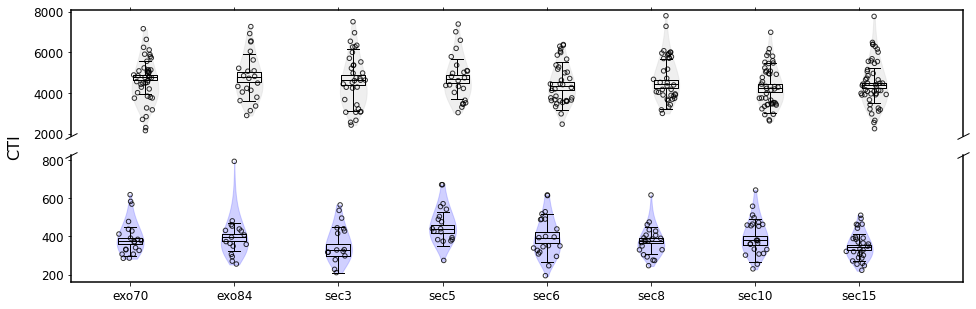

In [61]:
#+++++++++++++++++++++++++Loading files+++++++++++++++++++++++++++++++++++
home     = "/home/jsortiz/phd/Paper_Tethering/Copy_Number_LiveCell/"
maxI_ref = []
maxI_tar = []
for ids in ["exo70","exo84","sec3","sec5","sec6","sec8","sec10","sec15"]: # Loop over replicates
    
    data  = pd.read_csv(home+"240201_exocyst_copyNumber/_boxplot/%s.csv"%ids)        
    data["Set_ID"] = ids
    maxI_tar.append(data)    
    
    data  = pd.read_csv(home+"240201_exocyst_copyNumber/_boxplot/%s_ref.csv"%ids)
    data["Set_ID"] = ids
    maxI_ref.append(data)    
    
maxI_ref = pd.concat(maxI_ref,ignore_index=True)
maxI_tar = pd.concat(maxI_tar,ignore_index=True)
maxI_tar["CTI"] = maxI_tar["I_BG"]*9
maxI_ref["CTI"] = maxI_ref["I_BG"]*37
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#print("%10s \tDistal %16s %15s %12s"%("Set","N","Proximal","N"))
colors = {"Sec9_AA":"c","Sec2":"brown","WT":[0.4,0.4,1],"Sec9":"orange","Sec18_AA":"purple","WT_37C":'r',
          "Other":"y","Control":"lightblue"}

sets = maxI_tar["Set_ID"].unique()
n_cse4   = 76.8
err_cse4 = 9.8

fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(len(sets)*2,5))
fig.subplots_adjust(hspace=0.15)  # adjust space between Axes

print("%8s %6s %3s %20s"%("Subunit","","Ntracks","Median +- SEM CTI (a.u.)"))

for i,ids in enumerate(sets):    

    target  = maxI_tar.query("Set_ID=='%s' and Frames>=3"%ids)["CTI"].copy() 
    refer   = maxI_ref.query("Set_ID=='%s'"%ids)["CTI"].copy() 
    n,n_err,sig_tar,sig_ref = errn(target,refer,n_cse4,err_cse4)        

    for j in [0,1]:
        
        ax   = ax2 if j == 0 else ax1        
        idp  = ids if ids in ["Sec2","Sec9","Sec17","Sec18"] else "WT"        
   
        x    = target if j == 0 else refer
        mean = x.median()                
        nt   = len(x)
        sem  = sig_tar if j == 0 else sig_ref
        sd   = sem*np.sqrt(nt)    
        
        print("%8s %6s %3d %8.1f +- %3.1f"%(ids,"target" if j == 0 else "refer",len(x),mean,sem))
        
        denplot(x,xshift=3.5*i+ 0.5*j,ax=ax,style=2,color=colors[idp] if j == 0 else '.8',alpha=0.3)        
        
        ax.bxp([dict({
                "med"    : mean,
                "q1"     : mean-sem,
                "q3"     : mean+sem,
                "whislo" : mean-sd,
                "whishi" : mean+sd})],
               positions=[(3.5*i+ 0.5*j)],showfliers=False,patch_artist=False,               
               medianprops={"color":'.0','lw':1},
               widths=.8,zorder=50+j)
        ax.set_ylabel(None)
    
    print("%10s %3.1f +- %3.1f"% ("Copy number",n, n_err))
    print("++"*30)

ax1.set_xlim(-2,3.5*len(sets))

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

### Now, let's turn towards the cut-out slanted lines.
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig.text(0.07, 0.5, 'CTI', va='center', rotation='vertical',fontsize=16)
ax1.set_xticks(np.arange(len(sets))*3.5)
ax1.set_xticklabels(sets)
plt.show()

#plt.savefig("Figures/Copy_Number_Exocyst.svg")

## Fig3A & FigS9: Copy number of representative proteins involved in exocytosis
## Sec2 (vesicle transport) - Sec9 (vesicle fusion) - Sec17 & Sec18 (protein recycling)


 Subunit        Ntracks Median +- SEM CTI (a.u.)
    sec2 target  19    826.3 +- 25.8
    sec2  refer  40   7652.6 +- 349.7
Copy number 8.3 +- 1.2
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    sec9 target  25    510.5 +- 26.8
    sec9  refer  28   4409.8 +- 187.3
Copy number 8.9 +- 1.3
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
   sec17 target  17   1399.5 +- 61.8
   sec17  refer  32   4182.5 +- 171.2
Copy number 25.7 +- 3.6
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
   sec18 target  20   1751.1 +- 91.8
   sec18  refer  44   3678.9 +- 186.7
Copy number 36.6 +- 5.4
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


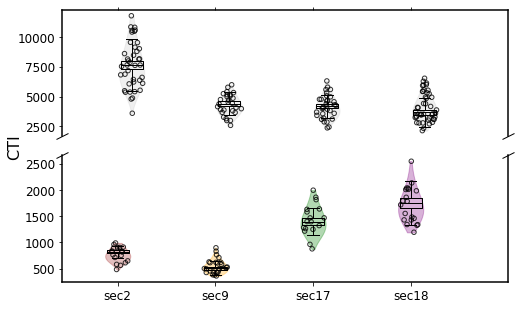

In [64]:
home     = "/home/jsortiz/phd/Paper_Tethering/Copy_Number_LiveCell/"
maxI_ref = []
maxI_tar = []
for ids in ["sec2","sec9","sec17","sec18"]: # Loop over replicates
    
    data  = pd.read_csv(home+"240319_copyNumber/_boxplot/%s.csv"%ids)        
    data["Set_ID"] = ids
    maxI_tar.append(data)    
    
    data  = pd.read_csv(home+"240319_copyNumber/_boxplot/%s_ref.csv"%ids)
    data["Set_ID"] = ids
    maxI_ref.append(data)    
    
maxI_ref = pd.concat(maxI_ref,ignore_index=True)
maxI_tar = pd.concat(maxI_tar,ignore_index=True)
maxI_tar["CTI"] = maxI_tar["I_BG"]*9
maxI_ref["CTI"] = maxI_ref["I_BG"]*37
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#print("%10s \tDistal %16s %15s %12s"%("Set","N","Proximal","N"))
colors = {"Sec9_AA":"c","sec2":"brown","WT":[0.4,0.4,1],"sec9":"orange","sec18":"purple","sec17":'g',
          "Other":"y","Control":"lightblue"}

sets = maxI_tar["Set_ID"].unique()
n_cse4   = 76.8
err_cse4 = 9.8

fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(len(sets)*2,5))
fig.subplots_adjust(hspace=0.15)  # adjust space between Axes

print("%8s %6s %3s %20s"%("Subunit","","Ntracks","Median +- SEM CTI (a.u.)"))

for i,ids in enumerate(sets):    

    target  = maxI_tar.query("Set_ID=='%s' and Frames>=3"%ids)["CTI"].copy() 
    refer   = maxI_ref.query("Set_ID=='%s'"%ids)["CTI"].copy() 
    n,n_err,sig_tar,sig_ref = errn(target,refer,n_cse4,err_cse4)    

    for j in [0,1]:
        
        ax   = ax2 if j == 0 else ax1        
        idp  = ids if ids in ["sec2","sec9","sec17","sec18"] else "WT"
        
        x    = target if j == 0 else refer
        mean = x.median()                
        nt   = len(x)
        sem  = sig_tar if j == 0 else sig_ref
        sd   = sem*np.sqrt(nt)    
        
        print("%8s %6s %3d %8.1f +- %3.1f"%(ids,"target" if j == 0 else "refer",len(x),mean,sem))        
        
        denplot(x,xshift=3.5*i+ 0.5*j,ax=ax,style=2,color=colors[idp] if j == 0 else '.8',alpha=0.3)
        
        
        ax.bxp([dict({
                "med"    : mean,
                "q1"     : mean-sem,
                "q3"     : mean+sem,
                "whislo" : mean-sd,
                "whishi" : mean+sd})],
               positions=[(3.5*i+ 0.5*j)],showfliers=False,patch_artist=False,               
               medianprops={"color":'.0','lw':1},
               widths=.8,zorder=50+j)
        ax.set_ylabel(None)
    
    print("%10s %3.1f +- %3.1f"% ("Copy number",n, n_err))
    print("++"*30)

ax1.set_xlim(-2,3.5*len(sets))

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

### Now, let's turn towards the cut-out slanted lines.
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig.text(0.03, 0.5, 'CTI', va='center', rotation='vertical',fontsize=16)
ax1.set_xticks(np.arange(len(sets))*3.5)
ax1.set_xticklabels(sets)
plt.show()

## Continue

In [ ]:
data =    pd.read_csv("../../../SuperResPaper2024/tracking_resume.csv")

In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(data=data,x="Replicate",y="Lifetime",hue="Replicate",palette="Greys")
plt.errorbar(x=data["Replicate"],y=data["Lifetime"],yerr=data["SD"],ls='',color='k',capsize=8)
plt.ylabel("Exo84\nLifetime (s)")
#plt.title("Exo84",fontsize=16)
plt.tight_layout()
plt.savefig("Figures/Lifetime_Exo84.png",dpi=200)

In [ ]:
data

In [ ]:
data_CH1["To_CH2_TfC1"] = data_CH1["To_CH2"]-data_CH1["Dur"]
data_CH1["Tf_CH2_TfC1"] = data_CH1["Tf_CH2"]-data_CH1["Dur"]

In [ ]:
data_CH1["Protein"].unique()

In [ ]:
def gradientbars(bars,color,t):
    
    col_map = LinearSegmentedColormap.from_list('custom blue', ['white',color], N=256)
    
    grad = np.atleast_2d(t).T
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(0)
        bar.set_facecolor("k")
        x,y = bar.get_xy()        
        w, h = bar.get_width(), bar.get_height()
        
        ax.imshow(grad.T, extent=[x,x+w,y,y+h], aspect="auto", zorder=1,cmap=col_map)
    ax.axis(lim)

fig, ax = plt.subplots(figsize=(7,5))
ax.set_facecolor("w")
fig.set_facecolor("w")

prots = ['Sec2','Sec9', 'Sec17', 'Sec18']
colors = {"Sec9_AA":"c","Sec2":"brown","Control":"b","Sec9":"orange","Sec18":"purple","Sec17":"y"}

data_aux = data_CH1.query("Protein in @prots").copy()
data_aux["Protein"] = data_aux["Protein"].astype("category")
data_aux["Protein"] = data_aux["Protein"].cat.remove_unused_categories()
data_aux['Protein'].cat.reorder_categories(prots,inplace=True)


dur = data_aux["Dur"].mean()
dur_std = data_aux["Dur"].mean()
ci = 1.96*dur_std/np.sqrt(len(data_aux))
bar= ax.barh(1.5,width=dur,left=0,label='Exo84',alpha=0.75)
ax.errorbar(dur,1.5, xerr=ci, yerr=0.,capsize=5,lw=2)
ax.text(-5,1.5,"Exo84",color="k",fontsize=14,ha='right')

"""
tc_C1 = data_sel["To_Factor_C1"]
tc_C1 = np.median(tc_C1)
t   = np.linspace(to,tf,256)
t   = np.exp(-(t-tc_C1)**2/(2*(to-tf)**2/5**2))
colors = np.array(sns.color_palette(palette="tab10",n_colors=1,as_cmap=True).colors)


gradientbars(bar,colors[0],t)
"""
for l,idprot in enumerate(prots):
    data_sel= data_aux.loc[data_aux["Protein"]==idprot].copy()
    n = len(data_sel)
    too     = data_sel["To_CH2"].mean()
    too_std = data_sel["To_CH2"].std()

    #too = too + to 
    tff     = data_sel["Tf_CH2"].mean()
    tff_std = data_sel["Tf_CH2"].std()    
    #tff = tff + tf
    
    """
    tc  = data_sel.loc[data_sel["Protein"]==idprot,"To_Factor_C2"].median()    
    tau = data_sel.loc[data_sel["Protein"]==idprot,"A_Factor_C2"].median()    
    b   = data_sel.loc[data_sel["Protein"]==idprot,"B_Factor_C2"].median()
    
    t   = np.linspace(too,tff,256)
    #t   = np.exp(-abs((t-tc)/tau)**(2*b))
    t   = np.exp(-(t-tc)**2/(2*(tff-too)**2/5**2))
    bar = ax.barh(-1.5*l,width=(tff-too),left=too,label=idprot)  
    gradientbars(bar,colors[l+1],t)
    """
    ci  = 1.96/np.sqrt(n)
    bar = ax.barh(-1.5*l,width=(tff-too),left=too,label=idprot,alpha=0.75,color=colors[idprot])  
    ax.errorbar(too,-1.5*l, xerr=too_std*ci, yerr=0.,capsize=5,lw=2,color=colors[idprot])
    ax.errorbar(tff,-1.5*l, xerr=tff_std*ci, yerr=0.,capsize=5,lw=2,color=colors[idprot])
    plt.text(-5,-1.5*l,idprot,color="k",fontsize=14,ha='right')

#ax.legend(fontsize=16)
ax.set_xlim(-10,20)
ax.set_ylim(-5,3)
ax.spines[['right','left','top']].set_visible(False)
ax.spines['bottom'].set_color('k')
plt.xticks(np.arange(-0,16,5),fontsize=16)
plt.yticks([])
plt.xlabel("Time (s)",fontsize=16)

plt.grid(False) 
plt.tight_layout()
plt.savefig("Figures/Time_Line_Bars_Exo84_Arrival.png",facecolor="w",transparent=False,dpi=300)

In [ ]:
data

In [ ]:
def box_lims(x):
    iqr = stats.iqr(x)
    low = np.quantile(x,0.25)-1.5*iqr
    upp = np.quantile(x,0.75)+1.5*iqr
    return(low,upp)
    

In [ ]:
aux = data_aux.query("Protein=='Sec18'").copy()
x   = aux["To_CH2_TfC1"]
low,upp = box_lims(x)
low,upp

In [ ]:
aux.query("To_CH2_TfC1>@low and To_CH2_TfC1<@upp  ")

In [ ]:
#data_CH1  = pd.read_csv("Final_ManualSel_Updated_2024-01-29.csv")
#data_CH1["To_CH2_TfC1"] = data_CH1["To_CH2"]-data_CH1["Dur"]
#data_CH1["Tf_CH2_TfC1"] = data_CH1["Tf_CH2"]-data_CH1["Dur"]
results   = []

for mode in [1,2]:
    for i,s in enumerate(["SEM"]): #enumerate(["","SD","CI","SEM"]):
        fig, ax = plt.subplots(figsize=(7,4))
        ax.set_facecolor(".96")
        fig.set_facecolor("w")

        prots = ['Sec2','Sec9', 'Sec18']
        colors = {"Sec9_AA":"c","Sec2":"brown","Control":"b","Sec9":"orange","Sec18":"purple","Sec17":"y"}

        data_aux = data_CH1.query("Protein in @prots").copy()
        data_aux["Protein"] = data_aux["Protein"].astype("category")
        data_aux["Protein"] = data_aux["Protein"].cat.remove_unused_categories()
        data_aux['Protein'].cat.reorder_categories(prots,inplace=True)        

        dy = 2

        dur     = data_aux["Dur"].mean()
        dur_std = data_aux["Dur"].std()     
        #dur     = data_aux.groupby("SET_ID")['Dur'].mean()
        dur_sem = data_aux.groupby("SET_ID")['Dur'].mean().std(ddof=1)

        if s == "SD":
            ci = 1
        elif s== "CI":
            ci = 1.96/np.sqrt(len(data_aux))
        if s == "SEM":
            dur_std = dur_sem
            ci = 1/np.sqrt(3)
        else:
            ci = 0

        bar= ax.barh(dy,width=dur,left=0,label='Exo84',alpha=[1,0.2][mode-1])
        if s != "":
            ax.errorbar(-dur+dur,dy, xerr=ci*dur_std, yerr=0.,capsize=5,lw=2,alpha=[0.2,1][1],color='k')
        #ax.text(-14,1.5,"Exo84",color="k",fontsize=14,ha='right')

        for l,idprot in enumerate(prots):
            data_sel= data_aux.loc[data_aux["Protein"]==idprot].copy()
            low,upp = box_lims(data_sel["To_CH2_TfC1"])
            #data_sel= data_sel.query("To_CH2_TfC1>@low and To_CH2_TfC1<@upp").copy()  
            low,upp = box_lims(data_sel["Tf_CH2_TfC1"]) 
            #data_sel= data_sel.query("Tf_CH2_TfC1>=@low and Tf_CH2_TfC1<=@upp").copy()

            n = len(data_sel)            
            too     = data_sel["To_CH2_TfC1"].mean()
            too_std = data_sel["To_CH2_TfC1"].std()
            too_sem = data_sel.groupby("SET_ID")[["To_CH2_TfC1"]].mean()
            too_sem = too_sem["To_CH2_TfC1"].std(ddof=1)

            tff     = data_sel["Tf_CH2_TfC1"].mean()
            tff_std = data_sel["Tf_CH2_TfC1"].std()
            tff_sem = data_sel.groupby("SET_ID")[["Tf_CH2_TfC1"]].mean()
            tff_sem = tff_sem["Tf_CH2_TfC1"].std(ddof=1)
            
            bar = ax.barh(-dy*l,width=(tff-too),left=too+dur,label=idprot,alpha=[1,0.2][0],color=colors[idprot])  

            if s == "SD":
                ci = 1
            elif s== "CI":
                ci = 1.96/np.sqrt(n)
            elif s== "SEM":
                ci = 1./np.sqrt(3)
                tff_std = tff_sem
                too_std = too_sem
            else:
                continue
                
            if mode==1 and s == "SEM":
                results.append([idprot,too,tff])

            ax.errorbar(too+dur,-dy*l, xerr=too_std*ci, yerr=0.,capsize=5,lw=2,color='k',alpha=[0.2,1][1])
            ax.errorbar(tff+dur,-dy*l, xerr=tff_std*ci, yerr=0.,capsize=5,lw=2,color='k',alpha=[0.2,1][1])
            if mode==1:
                print("%s %.2f %.2f %.2f %.2f %.2f %.2f"%(idprot,dur,dur_std*ci,too,too_std*ci,tff,tff_std*ci))
            #plt.text(-14,-1.5*l,idprot,color="k",fontsize=14,ha='right')

        #ax.legend(fontsize=16)
        ax.set_xlim(-2,16)
        ax.set_ylim(-dy*3-1.4,3)
        ax.set_yticks(np.arange(-dy*2,3,dy),np.flip(["Exo84"]+prots))

        ax.spines[['right','left','top']].set_visible(False)
        ax.spines['bottom'].set_color('k')
        plt.xticks(np.arange(0,20,5),fontsize=16)
        plt.xlabel("Time (s)",fontsize=16)

        plt.grid(False) 
        plt.tight_layout()
        plt.title(s,fontsize=12)
        plt.savefig("Figures/Time_Line_Bars_Exo84_Departure_%s_mode_%d.svg"%(s,mode),facecolor="w",transparent=False)

In [ ]:
prots = ['Sec2','Sec9', 'Sec18']
colors = {"Sec9_AA":"c","Sec2":"brown","Control":"b","Sec9":"orange","Sec18":"purple","Sec17":"y"}

data_aux = data_CH1.query("Protein in @prots").copy()
data_aux["Protein"] = data_aux["Protein"].astype("category")
data_aux["Protein"] = data_aux["Protein"].cat.remove_unused_categories()
data_aux['Protein'].cat.reorder_categories(prots,inplace=True)        


In [ ]:
data_aux[["Dur"]].mean()

In [ ]:
data_aux.groupby(["SET_ID"])[["Dur"]].mean()

In [ ]:
dur

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.barh(-dy*l,width=(tff-too),left=too,label=idprot,alpha=[1,0.2][mode-1],color=colors[idprot])  
plt.errorbar(too,-dy*l, xerr=too_std*ci, yerr=0.,color=colors[idprot],alpha=[0.2,1][mode-1])
plt.errorbar(tff,-dy*l, xerr=tff_std*ci, yerr=0.,color=colors[idprot],alpha=[0.2,1][mode-1])
plt.errorbar(too,-dy*l, xerr=too_std*ci, yerr=0.,capsize=5,lw=3,color=colors[idprot],alpha=0.2)
plt.errorbar(tff,-dy*l, xerr=tff_std*ci, yerr=0.,capsize=5,lw=3,color=colors[idprot],alpha=0.2)
plt.xlim(3.5,4.5)
plt.xlabel("Time (s)",fontsize=16)
plt.grid(False) 
plt.tight_layout()
plt.title(s,fontsize=12)

In [ ]:
results=pd.DataFrame(data=results,columns=["Protein","Arrival","Departure"])
#results.to_csv("~/Times.csv")

In [ ]:
results

In [ ]:
 data_CH1.query("Protein in @prots").groupby(["Protein","SET_ID"])[["To_CH2_TfC1","Tf_CH2_TfC1"]].count()

In [ ]:
#sns.scatterplot(data=data_CH1.query("Protein=='Sec9'"),x="To_CH2_TfC1",y="Tf_CH2_TfC1",hue='SET_ID')
sns.boxplot(data=data_CH1.query("Protein=='Sec18'"),x="To_CH2_TfC1")

In [ ]:
sns.boxplot(data=data_CH1.query("Protein=='Sec18'"),x="Dur")

In [ ]:
data_CH1.groupby("Protein")[["Dur","To","Mat_T","To_CH2","Tf_CH2","To_CH2_TfC1","Tf_CH2_TfC1","Dur_C2"]].mean()

In [ ]:
data_CH1.groupby("Protein")[["Dur","To","Mat_T","To_CH2","Tf_CH2","To_CH2_TfC1","Tf_CH2_TfC1","Dur_C2"]].median()

In [ ]:
9.48-0.795

In [ ]:
for mode in [1,2]:
    for i,s in enumerate(["","SD","CI"]):
        fig, ax = plt.subplots(figsize=(7,5))
        ax.set_facecolor(".96")
        fig.set_facecolor("w")

        prots = ['Sec2','Sec9', 'Sec17', 'Sec18']
        colors = {"Sec9_AA":"c","Sec2":"brown","Control":"b","Sec9":"orange","Sec18":"purple","Sec17":"y"}

        data_aux = data_CH1.query("Protein in @prots").copy()
        data_aux["Protein"] = data_aux["Protein"].cat.remove_unused_categories()
        data_aux['Protein'].cat.reorder_categories(prots,inplace=True)

        dy = 1.

        dur     = data_aux["Dur"].mean()
        dur_std = data_aux["Dur"].std()

        if s == "SD":
            ci = 1
        elif s== "CI":
            ci = 1.96/np.sqrt(len(data_aux))
        else:
            ci = 0

        bar= ax.barh(dy,width=-dur,left=0,label='Exo84',alpha=[1,0.2][mode-1])
        if s != "":
            ax.errorbar(-dur,dy, xerr=ci*dur_std, yerr=0.,capsize=5,lw=2,alpha=[0.2,1][mode-1])
        #ax.text(-14,1.5,"Exo84",color="k",fontsize=14,ha='right')

        for l,idprot in enumerate(prots):
            data_sel= data_aux.loc[data_aux["Protein"]==idprot].copy()
            #low,upp = box_lims(data_sel["To_CH2_TfC1"])
            data_sel= data_sel.query("To_CH2_TfC1>@low and To_CH2_TfC1<@upp").copy()  
            #low,upp = box_lims(data_sel["Tf_CH2_TfC1"]) 
            data_sel= data_sel.query("Tf_CH2_TfC1>=@low and Tf_CH2_TfC1<=@upp").copy()

            n = len(data_sel)
            too     = data_sel["To_CH2_TfC1"].mean()
            too_std = data_sel["To_CH2_TfC1"].std()

            tff     = data_sel["Tf_CH2_TfC1"].mean()
            tff_std = data_sel["Tf_CH2_TfC1"].std()
            
            bar = ax.barh(-dy*l,width=(tff-too),left=too,label=idprot,alpha=[1,0.2][mode-1],color=colors[idprot])  

            if s == "SD":
                ci = 1
            elif s== "CI":
                ci = 1.96/np.sqrt(n)
            else:
                continue

            ax.errorbar(too,-dy*l, xerr=too_std*ci, yerr=0.,capsize=5,lw=2,color=colors[idprot],alpha=[0.2,1][mode-1])
            ax.errorbar(tff,-dy*l, xerr=tff_std*ci, yerr=0.,capsize=5,lw=2,color=colors[idprot],alpha=[0.2,1][mode-1])
            #plt.text(-14,-1.5*l,idprot,color="k",fontsize=14,ha='right')

        #ax.legend(fontsize=16)
        ax.set_xlim(-20,10)
        ax.set_ylim(-dy*3-1.4,3)
        ax.set_yticks(np.arange(-dy*3,1.5,dy),np.flip(["Exo84"]+prots))

        ax.spines[['right','left','top']].set_visible(False)
        ax.spines['bottom'].set_color('k')
        plt.xticks(np.arange(-10,10,5),fontsize=16)
        plt.xlabel("Time (s)",fontsize=16)

        plt.grid(False) 
        plt.tight_layout()
        plt.savefig("Figures/Time_Line_Bars_Exo84_Departure_%s_mode_%d_close.png"%(s,mode),facecolor="w",transparent=False,dpi=300)

In [ ]:
data_aux["Protein"] = data_aux["Protein"].astype(str)
data_aux["Dur_C2"]  = data_aux["Tf_CH2"]-data_aux["To_CH2"]
data_sel = []

for idp in prots:  
    data = data_aux.query("Protein=='%s'"%idp).copy()
    low,upp = box_lims(data["To_CH2_TfC1"])    
    data = data.query("To_CH2_TfC1>=@low and To_CH2_TfC1<=@upp").copy()
    low,upp = box_lims(data["Tf_CH2_TfC1"])    
    data = data.query("Tf_CH2_TfC1>=@low and Tf_CH2_TfC1<=@upp").copy()
    data_sel.append(data)
    
data_sel = pd.concat(data_sel)
aux = data_sel.groupby(["Protein","SET_ID"])[["To_CH2_TfC1","Tf_CH2_TfC1","Dur_C2"]].agg(["mean","std","median"])
aux["count"] = data_sel.groupby(["Protein","SET_ID"])["FILE_ID"].count()

In [ ]:
print("Protein","Replicate","Ntracks",u"T_arrival(s) \u00B1 SD",u" T_departure(s) \u00B1 SD",
     u" Lifetime(s) \u00B1 SD")
for idp in prots:  
    print("%s"%"+"*85)    
    for ids in [0,1,2]:
        data = aux.loc[(idp,ids)].copy()              
        
        print("%5s"%idp,"%8d"%(ids+1),"%6d"%data["count"],
              u"%12.2f \u00B1%5.2f"%(data[("To_CH2_TfC1","mean")],data[("To_CH2_TfC1","std")]),
              u"%12.2f \u00B1%5.2f"%(data[("Tf_CH2_TfC1","mean")],data[("Tf_CH2_TfC1","std")]),
              u"%12.2f \u00B1%5.2f"%(data[("Dur_C2","mean")],data[("Dur_C2","std")]))
    
    #data = meanvalues.query("Set=='%s'"%s).copy()
    print("%12s"%"","%.10s"%"-"*72)
    data = data_sel.query("Protein=='%s'"%idp).copy()
    #data = data[["To_CH2_TfC1","Tf_CH2_TfC1","Dur_C2"]].agg(["mean","std","median","count"])    
    print("%5s"%"","%8s"%"All","%6d"%len(data),
          u"%12.2f \u00B1%5.2f"%(data["To_CH2_TfC1"].mean(),data["To_CH2_TfC1"].std()),
          u"%12.2f \u00B1%5.2f"%(data["Tf_CH2_TfC1"].mean(),data["Tf_CH2_TfC1"].std()),
          u"%12.2f \u00B1%5.2f"%(data["Dur_C2"].mean(),data["Dur_C2"].std()))
print("%s"%"+"*85)

In [ ]:
aux = data_sel.groupby(["Ref","SET_ID"])[["Dur"]].agg(["mean","std","median"])
aux["count"] = data_sel.groupby(["Ref","SET_ID"])["FILE_ID"].count()
aux

In [ ]:
print("Protein","Replicate","Ntracks",u" Lifetime(s) \u00B1 SD")
for idp in ["Exo84"]:  
    print("%s"%"+"*45)    
    for ids in [0,1,2]:
        data = aux.loc[(idp,ids)].copy()
        print("%5s"%idp,"%8d"%(ids+1),"%6d"%data["count"],              
              u"%12.2f \u00B1%5.2f"%(data[("Dur","mean")],data[("Dur","std")]))
    
    #data = meanvalues.query("Set=='%s'"%s).copy()
    print("%12s"%"","%.10s"%"-"*32)
    print("%5s"%"","%8s"%"All","%6d"%aux["count"].sum(),          
          u"%12.2f \u00B1%5.2f"%(aux.loc[idp,("Dur","mean")].mean(),aux.loc[idp,("Dur","std")].mean()))
print("%s"%"+"*45)

In [ ]:
prots = ['Sec2','Sec9', 'Sec17', 'Sec18']
colors = {"Sec9_AA":"c","Sec2":"brown","Control":"b","Sec9":"orange","Sec18":"purple","Sec17":"y"}

data_aux = data_CH1.query("Protein in @prots").copy()
data_aux["Protein"] = data_aux["Protein"].cat.remove_unused_categories()
data_aux['Protein'].cat.reorder_categories(prots,inplace=True)
data_aux["Ref"] = "Exo84"
data_aux.groupby(["Protein","SET_ID"])[["To_CH2_TfC1","Tf_CH2_TfC1"]].agg(["mean","std","count"])

In [ ]:
data_CH1["Dur"].mean()

In [ ]:
prots = ['Myo2','Sec2','Mso1', 'Sec9', 'Sec18', 'Sec17']
colors = {"Sec9_AA":"c","Sec2":"brown","Control":"b","Sec9":"orange","Sec18":"purple","Sec17":"y"}


data_aux = data_CH1.query("Protein in @prots").copy()
data_aux["Protein"] = data_aux["Protein"].cat.remove_unused_categories()
data_aux['Protein'].cat.reorder_categories(prots,inplace=True)
data_aux["Ref"] = "Exo84"

sns.boxplot(data=data_aux,x="Tf_CH2",y="Protein",hue="Protein",legend=False,linewidth=1.5,)
sns.boxplot(data=data_aux,x="To_CH2",y="Protein",hue="Protein",legend=False,
            boxprops=dict(alpha=.5),linewidth=1.5,linecolor=".5") 
plt.axvline(data_CH1["TRACK_DURATION"].mean(),color='.5',ls='-',lw=8,alpha=.5)
plt.xlabel("Time (s)")

plt.show()

In [ ]:

fig, ax = plt.subplots(figsize=(7,5))
prots = ['Sec2','Sec9', 'Sec17', 'Sec18']
colors = {"Sec9_AA":"c","Sec2":"brown","Control":"b","Sec9":"orange","Sec18":"purple","Sec17":"y"}

data_aux = data_CH1.query("Protein in @prots").copy()
data_aux["Protein"] = data_aux["Protein"].cat.remove_unused_categories()
data_aux['Protein'].cat.reorder_categories(prots,inplace=True)
data_aux["Ref"] = "Exo84"

sns.boxplot(data=data_aux,x=-data_aux["Dur"],y=data_aux["Ref"].values ,legend=False,linewidth=1.5,
            linecolor="0",ax=ax,fliersize=0)
sns.boxplot(data=data_aux,x="Tf_CH2_TfC1",y=data_aux["Protein"].values,hue="Protein",legend=False,linewidth=1.5,
            palette=colors,ax=ax,fliersize=0)
sns.boxplot(data=data_aux,x="To_CH2_TfC1",y=data_aux["Protein"].values,hue="Protein",legend=False,
            boxprops=dict(alpha=1),linewidth=1.5,linecolor="0",palette=colors,ax=ax,fliersize=0) 
#plt.axvline(-data_CH1["TRACK_DURATION"].mean(),color='.5',ls='-',lw=8,alpha=.5)

"""
data_aux = data_aux.groupby(["Protein","SET_ID"])[["To_CH2_TfC1","Tf_CH2_TfC1"]].median().reset_index()


sns.scatterplot(data=data_aux,y=data_aux["Protein"].values,x="To_CH2_TfC1",
                hue="Protein",palette=colors,legend=False,style='SET_ID',s=80,edgecolor='k',zorder=0,ax=ax)

sns.scatterplot(data=data_aux,y=data_aux["Protein"].values,x="Tf_CH2_TfC1",
                hue="Protein",palette=colors,legend=False,style='SET_ID',s=80,edgecolor='k',zorder=5,ax=ax)
"""

ax.set_xlim(-20,10)
#ax.set_xlim(-15,10)

#ax.set_ylim(-5,3)
ax.spines[['right','left','top']].set_visible(False)
ax.spines['bottom'].set_color('k')
plt.xticks(np.arange(-10,10,5),fontsize=16)
plt.xlabel("Time (s)",fontsize=16)
plt.tight_layout()
plt.savefig("Figures/Protein_times_vs_Departure_Exo84_time.png",dpi=200,facecolor=None,transparent=True)

In [ ]:
sns.boxplot(data=data_aux,x="To_CH2_TfC1",y=data_aux["Protein"].values,hue="Protein",legend=False,
            boxprops=dict(alpha=1),linewidth=1.5,linecolor="0",palette=colors,fliersize=10)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
prots = ['Sec2','Sec9', 'Sec17', 'Sec18']
data_aux = data_CH1.query("Protein in @prots").copy()
data_aux["Protein"] = data_aux["Protein"].cat.remove_unused_categories()
data_aux['Protein'].cat.reorder_categories(prots,inplace=True)
data_aux["Ref"] = "Exo84"
sns.boxplot(data=data_aux,x="Dur",y="Ref" ,legend=True,linewidth=1.5)
sns.boxplot(data=data_aux,x="Tf_CH2",y="Protein",hue="Protein",legend=False,linewidth=1.5,palette=colors,ax=ax)
sns.boxplot(data=data_aux,x="To_CH2",y="Protein",hue="Protein",legend=False,palette=colors,ax=ax,
            boxprops=dict(alpha=.5),linewidth=1.5,linecolor=".5") 
#plt.axvline(data_CH1["TRACK_DURATION"].mean(),color='.5',ls='-',lw=8,alpha=.5)
data_aux = data_aux.groupby(["Protein","SET_ID"])[["To_CH2","Tf_CH2"]].median().reset_index()

sns.scatterplot(data=data_aux,y="Protein",x="To_CH2",
                hue="Protein",palette=colors,legend=False,style='SET_ID',s=80,edgecolor='k',zorder=1,ax=ax)

sns.scatterplot(data=data_aux,y="Protein",x="Tf_CH2",
                hue="Protein",palette=colors,legend=False,style='SET_ID',s=80,edgecolor='k',zorder=2,ax=ax)

#plt.show()

#plt.show()
ax.set_xlim(-10,20)
#ax.set_ylim(-5,3)
ax.spines[['right','left','top']].set_visible(False)
ax.spines['bottom'].set_color('k')
plt.xticks(np.arange(-0,16,5),fontsize=16)
#plt.yticks([])
plt.xlabel("Time (s)",fontsize=16)

plt.grid(False) 
plt.tight_layout()
plt.tight_layout()
plt.savefig("Figures/Protein_times_vs_Arrival_Exo84_time.png",dpi=200,facecolor=None,transparent=True)

In [ ]:

sns.scatterplot(data=data_aux,y="Protein",x="To_CH2",
                hue="Protein",palette="tab10",legend=False,style='SET_ID',s=80)

sns.scatterplot(data=data_aux,y="Protein",x="Tf_CH2",
                hue="Protein",palette="tab10",legend=False,style='SET_ID',s=80,zorder=1)

In [ ]:
prots = ['Sec2','Sec9', 'Sec18', 'Sec17']
data_aux = data_CH1.query("Protein in @prots").copy()
data_aux["Protein"] = data_aux["Protein"].cat.remove_unused_categories()
data_aux['Protein'].cat.reorder_categories(prots,inplace=True)
data_aux.groupby(["Protein","SET_ID"])[["To_CH2","Tf_CH2"]].count()


In [ ]:
sns.scatterplot(data=data_aux.query("Protein=='Sec18'"),x="Dur",y="To_CH2")

In [ ]:
fit = []
for i in ["Sec2","Sec9","Sec17","Sec18"]:
    data = data_aux.query("""Protein==@i and Dur<15""").copy()
    fit.append(list(stats.linregress(data["Dur"],data["To_CH2"]))+[i])
    sns.regplot(data=data,x="Dur",y="To_CH2")
fit = pd.DataFrame(fit,columns=["slope","intercept","rvalue","pvalue","stderr","Protein"])
fit

In [ ]:
fit = []
for i in ["Sec2","Sec9","Sec17","Sec18"]:
    data = data_aux.query("""Protein==@i and Dur<15""").copy()
    fit.append(list(stats.linregress(data["Dur"],data["Tf_CH2"]))+[i])
    sns.regplot(data=data,x="Dur",y="Tf_CH2")
fit = pd.DataFrame(fit,columns=["slope","intercept","rvalue","pvalue","stderr","Protein"])
fit

# SMLM Classification / Copy number / Averaging

In [ ]:
# 

In [ ]:
x = spots["POSITION_X"].values
y = spots["POSITION_Y"].values
d = np.sqrt((x-x[0])**2+(y-y[0])**2)

In [ ]:
plt.scatter(x,y)

In [ ]:
plt.plot(d)

In [65]:
# SMLM Copy number